In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## 0. Loading the data

In [2]:
def load_data(filepath):
    """
    Loading the data from the given file path and keeping only the desired features.
    """
    data = pd.read_csv(filepath)

    # why do we keep 'rawValue' instead of 'value'
    features = ['value', 'state', 'day_of_week', 'hour_of_day', 'month_of_year', 'day_of_month']

    data = data[features]
    return data


In [3]:
filepath = 'data/15048_O3_2022_processed.csv'
data = load_data(filepath)
data.head()

,rawValue,state,day_of_week,hour_of_day,month_of_year,day_of_month
0,2.8,1,5,1,1,1
1,3.2,1,5,2,1,1
2,2.4,1,5,3,1,1
3,2.4,1,5,4,1,1
4,2.8,1,5,5,1,1


In [4]:
def separate_features_and_label(data):
    """
    Separating the features from the label.
    """
    X = data.loc[:, data.columns != 'state']
    y = data['state']
    return X, y

In [5]:
X, y = separate_features_and_label(data)

## 1. Sampling the data

The data we load from our files is already cleaned. However, the distribution of valid and invalid instances is uneven and thus requires further pre-processing. Sampling should handle this imbalance effectively.

In [6]:
def get_distribution(y):
    """
    Getting the distribution of valid and invalid data instances.
    """
    return y.value_counts(normalize=True)
    

In [7]:
get_distribution(y)

1    0.956735
0    0.043265
Name: state, dtype: float64

In [8]:
def no_sampling(X, y):
    return X, y

### 1.1 Undersampling

*Random Undersampling*

Shrinks the dataset enormously most of the cases and may discard informative instances.

In [9]:
def undersample_random(X, y):
    """
    Randomly remove instances from the majority class until a more balanced distribution is achieved. 
    """
    X_res, y_res = RandomUnderSampler().fit_resample(X, y)
    return X_res, y_res

In [10]:
_, y_rus = undersample_random(X, y)
len(y_rus) / len(y)

0.08653082826144483

*Tomek Links*

Makes the decision boundary more distinct but does not help much with the imbalance in our dataset.

In [11]:
def undersample_tomeklinks(X, y):
    """
    Identify pairs of instances, one from the majority class and one from the minority class, that are close to each other but are of different classes. 
    Remove the majority class instance in each pair.    
    """
    X_res, y_res = TomekLinks().fit_resample(X, y)
    return X_res, y_res

In [12]:
_, y_tl = undersample_tomeklinks(X, y)
get_distribution(y_tl)

1    0.956694
0    0.043306
Name: state, dtype: float64

### 1.2 Oversampling

*Random Oversampling*

Doubles the size of the dataset in most of our cases but does not add new information.

In [13]:
def oversample_random(X, y):
    """
    Randomly duplicate instances from the minority class to increase their representation in the dataset.
    """
    X_res, y_res = RandomOverSampler().fit_resample(X, y)
    return X_res, y_res

In [14]:
_, y_ros = oversample_random(X, y)
len(y_ros) / len(y)

1.9134691717385552

*Synthetic Minority Over-sampling Technique (SMOTE)*

SMOTE helps in avoiding overfitting by introducing diversity through synthetic samples for the minority class. However, introducing synthetic samples may result in intentional misclassification, as synthetic samples might not accurately represent the characteristics of the original data.

In [15]:
def oversample_SMOTE(X, y):
    """
    SMOTE generates synthetic samples for the minority class by interpolating between existing instances.
    It selects a minority class instance and its k nearest neighbors, 
    and then creates synthetic instances along the line segments connecting the selected instance to its neighbors.
    """
    X_res, y_res = SMOTE().fit_resample(X, y)
    return X_res, y_res

In [16]:
_, y_smote = oversample_SMOTE(X, y)
print(len(y_smote)/ len(y))

1.9134691717385552


*Simulation of drifts* (similar to J. Dutroncy)

In [17]:
def oversample_drift(X, y):
    """
    The simulated drift feeds the training dataset with data undergoing a modification, and whose associated labels are determined to be “invalid”.
    """
    valid_indices = y == 1
    valid_instances = X[valid_indices]

    # number of instances to modify to achieve balance
    num_to_modify = sum(y == 1) - sum(y == 0)
    
    # select random instances to modify
    indices_to_modify = np.random.choice(valid_instances.index, size=num_to_modify, replace=False)

    # add random offset to selected instances
    modified_instances = X.loc[indices_to_modify].copy()
    range = X['value'].max() - X['value'].min()
    min_offset = .1 * range
    max_offset = .3 * range
    modified_instances['value'] += np.random.uniform(min_offset, max_offset, size=num_to_modify) * np.random.choice([-1, 1])

    # mark modified instances as invalid
    invalids = pd.Series([0] * num_to_modify)

    # concatenate modified instances with the original dataset
    X_mod = pd.concat([X, modified_instances], ignore_index=True)
    y_mod = pd.concat([y, invalids], ignore_index=True)

    return X_mod, y_mod

In [18]:
oversample_drift(X, y)

(         rawValue  day_of_week  hour_of_day  month_of_year  day_of_month
 0        2.800000            5            1              1             1
 1        3.200000            5            2              1             1
 2        2.400000            5            3              1             1
 3        2.400000            5            4              1             1
 4        2.800000            5            5              1             1
 ...           ...          ...          ...            ...           ...
 14457 -108.243506            5           23              1             1
 14458  -83.509949            5            0             10             8
 14459    4.337874            6           14              5             1
 14460   47.155610            4           12              3            25
 14461  -30.303185            2            4              2             2
 
 [14462 rows x 5 columns],
 0        1
 1        1
 2        1
 3        1
 4        1
         ..
 14457    0

## 2. Classification

### 2.0 Train-test split

In [19]:
def split_data(X, y, test_size, stratifed=False):
    """ 
    Splitting the data into train and test sets.
    Stratifying to maintaining the proportions of the states in each set.
    """
    if stratifed:
        return train_test_split(X, y, test_size=test_size, stratify=y)
    else:
        return train_test_split(X, y, test_size=test_size)
    

In [20]:
_, _, y_train, y_test = split_data(X, y, .3, True)
print(get_distribution(y_train))
print(get_distribution(y_test))

1    0.956711
0    0.043289
Name: state, dtype: float64
1    0.95679
0    0.04321
Name: state, dtype: float64


### 2.1 Random Forest

Random Forest can handle imbalanced datasets well due to its bagging nature and the use of multiple decision trees.

In [21]:
def classify_random_forest(X_train, X_test, y_train):
    """ 
    Classify the given data with RandomForest.
    """
    clf = RandomForestClassifier().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    return y_pred, y_prob

### 2.2 Isolation Forest

Isolation forest is a classification method that handels the minority class as an anomaly. It is based on the principle that anomalies are few in number and have characteristics that make them stand out from the regular instances.

In [22]:
def classify_isolation_forest(X_train, X_test, y_train):
    """ 
    Classify the given data with IsolationForest.
    IsolationForest works by recursively partitioning the data and isolating instances that require fewer partitions as potential anomalies.
    """
    prop = y_train.eq(0).sum() / len(y_train)   # proportion of outliers
    clf = IsolationForest(contamination=prop).fit(X_train, y_train)

    # normalize anomaly score to obtain confidence measure
    anomaly_scores = clf.decision_function(X_test)
    y_prob = MinMaxScaler().fit_transform(anomaly_scores.reshape(-1, 1))

    y_pred = clf.predict(X_test)
    y_pred[y_pred == -1] = 0    # IsolationForest classifies outliers as -1

    return y_pred, y_prob

## 3. Evaluation

In [23]:
def evaluate(y_test, y_pred):
    precision = precision_score(y_test, y_pred, labels=[0], average=None)[0]     # true negatives out of all negative predictions
    recall = recall_score(y_test, y_pred, labels=[0], average=None)[0]           # true negatives out of all truly negatives
    print(f'Precision: {precision}\nRecall: {recall}')
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    #plt.title('Confusion Matrix')
    #plt.show()

In [24]:
def run_classification(trainfile, testfile=None, undersampler=no_sampling, oversampler=no_sampling, classifier=classify_random_forest):
    if testfile is None:
        data = load_data(trainfile)
        X, y = separate_features_and_label(data)
        X_train, X_test, y_train, y_test = split_data(X, y, .3, stratifed=True)
    else:
        train = load_data(trainfile)
        X_train, y_train = separate_features_and_label(train)
        test = load_data(testfile)
        X_test, y_test = separate_features_and_label(test)

    X_train, y_train = oversampler(X_train, y_train)
    X_train, y_train = undersampler(X_train, y_train)

    y_pred, y_prob = classifier(X_train, X_test, y_train)

    evaluate(y_test, y_pred)

In [25]:
train_filepath = 'data/15048_O3_2022_processed.csv'
test_filepath = 'data/15038_O3_2022_processed.csv'

*Original data set only*

Precision: 0.98989898989899
Recall: 1.0


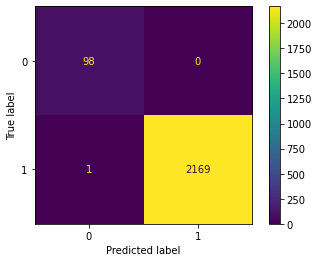

In [26]:
run_classification(train_filepath, classifier=classify_random_forest)

Precision: 0.25688073394495414
Recall: 0.2857142857142857


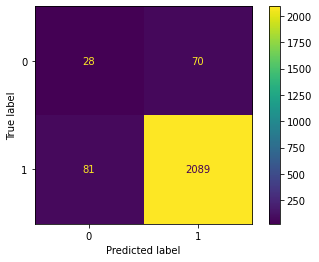

In [27]:
run_classification(train_filepath, classifier=classify_isolation_forest)

*Oversampled dataset using SMOTE*

Precision: 0.9797979797979798
Recall: 0.9897959183673469


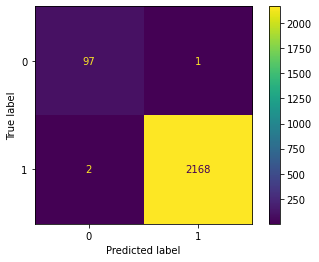

In [28]:
run_classification(train_filepath, oversampler=oversample_SMOTE, classifier=classify_random_forest)

*Oversamples dataset using drift*

Precision: 0.9514563106796117
Recall: 1.0


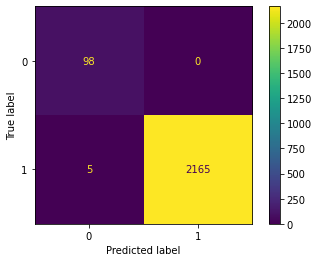

In [29]:
run_classification(train_filepath, oversampler=oversample_drift, classifier=classify_random_forest)

*Different sites*

Precision: 0.1111111111111111
Recall: 0.2


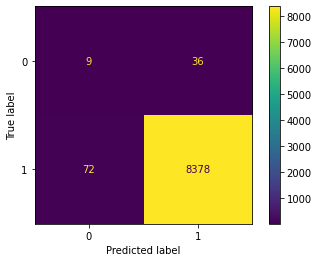

In [30]:
run_classification(train_filepath, test_filepath, classifier=classify_random_forest)

Precision: 0.0
Recall: 0.0


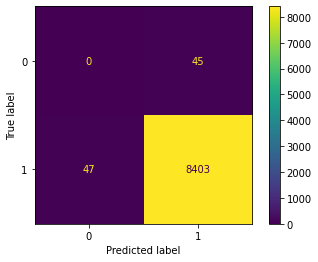

In [31]:
run_classification(train_filepath, test_filepath, oversampler=oversample_random, classifier=classify_random_forest)

Precision: 0.013404825737265416
Recall: 0.1111111111111111


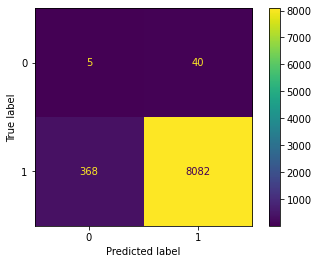

In [32]:
run_classification(train_filepath, test_filepath, oversampler=oversample_SMOTE, classifier=classify_random_forest)

Precision: 0.025191675794085433
Recall: 0.5111111111111111


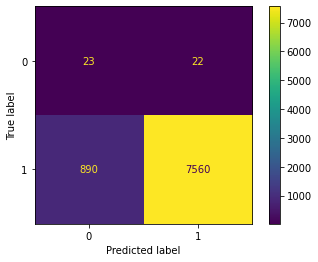

In [33]:
run_classification(train_filepath, test_filepath, oversampler=oversample_drift, classifier=classify_random_forest)

*Multiple sites*

In [ ]:
from fetch import 